# 

# Submit a task with constraints based on a previous task

In [1]:
# Get first task parameters
import pystac_client
import os
import geopandas as gpd
import pandas as pd
import requests
import xyzservices
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
API = "https://api.canopy.umbra.space"
SANDBOX_API = "https://api.canopy.prod.umbra-sandbox.space"

In [3]:
# Get actual acquired image from previous task
task_id = '380908ae-be21-476d-8a0e-f5c177e8107e'


stac_api_url = "https://api.canopy.umbra.space/v2/stac/"
catalog = pystac_client.Client.open(stac_api_url,
                                    headers={"authorization": f"Bearer {os.environ.get('UMBRA_API_TOKEN')}" }
)

cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:task_id"
      },
      task_id
    ]
  }

stac_search = catalog.search(
   collections=["umbra-sar"], 
   filter=cql2filter,
)

items = stac_search.item_collection()
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
gf.iloc[0]

geometry                                    POLYGON Z ((-121.79070042751859 46.79942866815...
created                                                      2024-10-18T22:22:41.027465+00:00
updated                                                      2024-10-18T22:22:41.027483+00:00
datetime                                                          2024-10-18T19:14:02.800000Z
platform                                                                             Umbra-08
end_datetime                                                 2024-10-18T19:14:03.599999+00:00
view:azimuth                                                                       319.772948
umbra:task_id                                            380908ae-be21-476d-8a0e-f5c177e8107e
start_datetime                                                      2024-10-18T19:14:02+00:00
sar:looks_range                                                                             1
sar:product_type                                            

In [4]:
gf.explore(popup=True, tiles=xyzservices.providers.Esri.WorldImagery)

In [5]:
# Get task submission parameters
# Check task status
API = "https://api.canopy.umbra.space"

url = f"{API}/tasking/tasks/{task_id}"

headers = {
    "authorization": f"Bearer {os.environ['UMBRA_API_TOKEN']}"
}

response = requests.get(url, headers=headers)
previous_task = response.json()
previous_task

{'id': '380908ae-be21-476d-8a0e-f5c177e8107e',
 'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-121.74456, 46.79679, 1589.0]},
 'properties': {'imagingMode': 'SPOTLIGHT',
  'spotlightConstraints': {'geometry': {'type': 'Point',
    'coordinates': [-121.74456, 46.79679, 1589.0]},
   'polarization': 'VV',
   'rangeResolutionMinMeters': 1.0,
   'multilookFactor': 1,
   'grazingAngleMinDegrees': 42,
   'grazingAngleMaxDegrees': 80,
   'targetAzimuthAngleStartDegrees': 0,
   'targetAzimuthAngleEndDegrees': 360,
   'sceneSize': '5x5_KM'},
  'windowStartAt': '2024-10-18T16:44:36+00:00',
  'windowEndAt': '2024-10-25T16:44:36+00:00',
  'deliveryConfigId': None,
  'productTypes': ['GEC', 'SIDD', 'SICD', 'CPHD'],
  'tags': ['paradise', 'uw'],
  'taskName': 'paradise1',
  'userOrderId': '',
  'satelliteIds': ['Umbra-05', 'Umbra-08', 'Umbra-09', 'Umbra-10'],
  'id': '380908ae-be21-476d-8a0e-f5c177e8107e',
  'createdAt': '2024-10-18T13:32:51.204523+00:00',
  'updatedAt': '2024-10-

In [6]:
# Search one week into the future
# Umbra suggests at least 90min into future to allow for scheduling
now = gpd.pd.Timestamp.now().floor('s') + gpd.pd.Timedelta(minutes=90)
next_week = now + gpd.pd.Timedelta(days=7)
next_month = now + gpd.pd.Timedelta(days=30)
# Umbra API requires Z at end (UTC)
print(now.isoformat()+'Z', next_week.isoformat()+'Z')

2024-10-25T14:12:27Z 2024-11-01T14:12:27Z


In [7]:
# REQUEST feasibilities

url = f"{API}/tasking/feasibilities"
payload = {
    "imagingMode": "SPOTLIGHT",
    "spotlightConstraints": previous_task['properties']['spotlightConstraints'],
    "windowStartAt": now.isoformat()+'Z',
    "windowEndAt": next_week.isoformat()+'Z',
}

# Add acquitision constraints
#payload['spotlightConstraints'].update(acquitision)
print(payload) 

headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "authorization": f"Bearer {os.environ['UMBRA_API_TOKEN']}"
}

response = requests.post(url, json=payload, headers=headers)

{'imagingMode': 'SPOTLIGHT', 'spotlightConstraints': {'geometry': {'type': 'Point', 'coordinates': [-121.74456, 46.79679, 1589.0]}, 'polarization': 'VV', 'rangeResolutionMinMeters': 1.0, 'multilookFactor': 1, 'grazingAngleMinDegrees': 42, 'grazingAngleMaxDegrees': 80, 'targetAzimuthAngleStartDegrees': 0, 'targetAzimuthAngleEndDegrees': 360, 'sceneSize': '5x5_KM'}, 'windowStartAt': '2024-10-25T14:12:27Z', 'windowEndAt': '2024-11-01T14:12:27Z'}


In [9]:
# RETRIEVE feasibilities (wait ~20s after requesting)

url = f"{API}/tasking/feasibilities/{response.json()['id']}"

response = requests.get(url, headers=headers)

df = pd.DataFrame(response.json()['opportunities'])
df

,windowStartAt,windowEndAt,durationSec,grazingAngleStartDegrees,grazingAngleEndDegrees,targetAzimuthAngleStartDegrees,targetAzimuthAngleEndDegrees,squintAngleStartDegrees,squintAngleEndDegrees,squintAngleEngineeringDegreesStart,squintAngleEngineeringDegreesEnd,slantRangeStartKm,slantRangeEndKm,groundRangeStartKm,groundRangeEndKm,satelliteId
0,2024-10-25T18:32:48+00:00,2024-10-25T18:43:45+00:00,57.0,44.018721,42.040283,78.698294,127.930855,20.321755,-28.447338,69.678245,118.447338,705.566928,729.039757,469.943908,502.810698,Umbra-08
1,2024-10-26T04:59:48+00:00,2024-10-26T05:11:12+00:00,84.0,47.759192,47.885786,214.319664,304.387287,44.864471,-44.575936,45.135529,134.575936,679.704246,677.990262,424.139594,419.828531,Umbra-05
2,2024-10-26T05:37:38+00:00,2024-10-26T05:48:25+00:00,47.0,42.095924,42.076928,87.628977,53.960005,163.097656,-163.070294,-73.097656,-106.929706,835.824034,835.645655,568.487895,567.491887,Umbra-10
3,2024-10-26T06:02:13+00:00,2024-10-26T06:12:20+00:00,7.0,76.996194,79.754774,118.633798,97.187051,136.561753,158.047315,-46.561753,-68.047315,603.168681,597.689599,125.115565,97.557796,Umbra-09
4,2024-10-26T06:02:30+00:00,2024-10-26T06:12:38+00:00,8.0,79.854222,76.688211,54.823418,30.484663,-159.533084,-135.149121,-110.466916,-134.850879,597.444182,603.670227,95.303670,125.664901,Umbra-09
5,2024-10-26T18:02:04+00:00,2024-10-26T18:13:20+00:00,76.0,50.660527,50.696317,330.287387,241.751183,135.552674,-135.553566,-45.552674,-134.446434,658.908504,659.541095,384.778982,387.072602,Umbra-05
6,2024-10-26T18:50:55+00:00,2024-10-26T19:02:26+00:00,91.0,47.119355,42.149919,69.034718,143.172582,30.605786,-42.809730,59.394214,132.809730,775.071756,835.902820,482.653025,569.472981,Umbra-10
7,2024-10-27T05:42:17+00:00,2024-10-27T05:53:55+00:00,98.0,42.182773,42.130635,108.946799,34.478509,142.603845,-142.545450,-52.603845,-127.454550,834.802359,834.571912,567.665960,565.807448,Umbra-10
8,2024-10-27T18:56:09+00:00,2024-10-27T19:07:20+00:00,71.0,55.168560,49.400637,71.194434,145.560641,29.439595,-44.395343,60.560405,134.395343,701.918816,752.002914,366.665676,449.827585,Umbra-10
9,2024-10-27T19:21:18+00:00,2024-10-27T19:32:01+00:00,43.0,67.894543,68.253530,330.160080,241.567894,135.078122,-136.101843,-45.078122,-133.898157,630.748095,629.626756,215.719999,214.443667,Umbra-09


In [10]:
df.to_csv('feasibilities-paradise-2024-10-25.csv')

In [11]:
# midpoints
df['targetAzimuthAngle'] = (df['targetAzimuthAngleEndDegrees'] - df['targetAzimuthAngleStartDegrees'])/2 + df['targetAzimuthAngleStartDegrees']
df['grazingAngle'] = (df['grazingAngleEndDegrees'] - df['grazingAngleStartDegrees'])/2 + df['grazingAngleStartDegrees']
df['squintAngleEngineering'] = (df['squintAngleEngineeringDegreesEnd'] - df['squintAngleEngineeringDegreesStart'])/2 + df['squintAngleEngineeringDegreesStart']

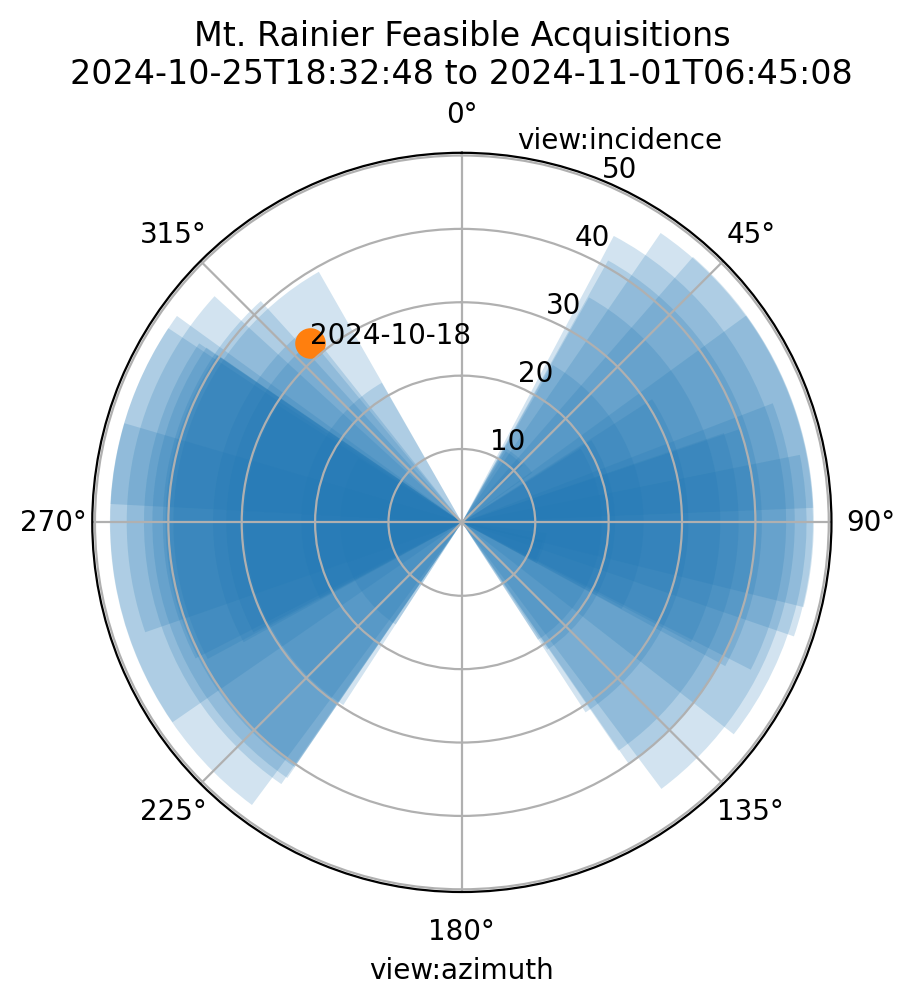

In [12]:
# Quick plot of acquisition geometries 

theta = np.deg2rad(df['targetAzimuthAngle'])
radii = 90-df['grazingAngle'] #incidence angle
width = np.deg2rad(df['targetAzimuthAngleEndDegrees'] - df['targetAzimuthAngleStartDegrees'])

colors = df.squintAngleEngineering
colors /= np.max(np.abs(colors),axis=0) 
#colors = plt.cm.bwr(colors) 
colors = plt.cm.Spectral_r(colors)
colors = None

# Clockwise, north=0
ax = plt.subplot(projection='polar')
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

ax.bar(theta, radii, width=width, color=colors, alpha=0.2) #add colorbar?
#ax.bar(np.deg2rad(135), 30, width=np.deg2rad(45), bottom=0.0, color='m', alpha=0.5)

# Add previous acquisition
ax.scatter(np.deg2rad(gf['view:azimuth']), 
           90-gf['umbra:grazing_angle_degrees'], 
           #color='r', 
           s=100)
ax.text(np.deg2rad(gf['view:azimuth'].iloc[0]), 
           90-gf['umbra:grazing_angle_degrees'].iloc[0], 
           #gf['umbra:task_id'].iloc[0]
           gf['datetime'].iloc[0][:10]
)

label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position), ax.get_rmax()+6,'view:incidence',
        rotation=None, ha='center',va='center')

ax.set_xlabel('view:azimuth')

titlestr = f'Mt. Rainier Feasible Acquisitions\n{df['windowStartAt'].min().rstrip('+00:00')} to {df['windowEndAt'].max().rstrip('+00:00')}'
plt.title(titlestr);

In [13]:
# Downselect based on actual *acquired* grazing angle target_azimuth and squint
azimuth_tolerance = 10 # degrees
incidence_tolerance = 10 # degrees
#squint_tolerance = 10 #ignore for now

# convert to a series
s = gf[ ['view:azimuth','view:incidence_angle','umbra:squint_angle_engineering_degrees']].iloc[0]

In [14]:
# search midpoints rather than overlapping range
min_azimuth = int(s['view:azimuth'] - azimuth_tolerance)
max_azimuth = int(s['view:azimuth'] + azimuth_tolerance)
print('Allowed Azimuth Range:', min_azimuth, max_azimuth)
within_azimuth = (df['targetAzimuthAngleStartDegrees'] >= min_azimuth) & (df['targetAzimuthAngleEndDegrees'] <= max_azimuth)


min_incidence = int(s['view:incidence_angle'] - incidence_tolerance)
max_incidence = int(s['view:incidence_angle']+ incidence_tolerance)
print('Allowed Incidence Range:', min_incidence, max_incidence)
# min indcidence = max grazing
print('Allowed Grazing Angle Range:', 90-max_incidence, 90-min_incidence)
within_incidence = (90-df['grazingAngleStartDegrees'] >= min_incidence) & (90-df['grazingAngleEndDegrees'] <= max_incidence)

subset = df[within_incidence & within_azimuth]
subset

Allowed Azimuth Range: 309 329
Allowed Incidence Range: 21 41
Allowed Grazing Angle Range: 49 69


,windowStartAt,windowEndAt,durationSec,grazingAngleStartDegrees,grazingAngleEndDegrees,targetAzimuthAngleStartDegrees,targetAzimuthAngleEndDegrees,squintAngleStartDegrees,squintAngleEndDegrees,squintAngleEngineeringDegreesStart,squintAngleEngineeringDegreesEnd,slantRangeStartKm,slantRangeEndKm,groundRangeStartKm,groundRangeEndKm,satelliteId,targetAzimuthAngle,grazingAngle,squintAngleEngineering
5,2024-10-26T18:02:04+00:00,2024-10-26T18:13:20+00:00,76.0,50.660527,50.696317,330.287387,241.751183,135.552674,-135.553566,-45.552674,-134.446434,658.908504,659.541095,384.778982,387.072602,Umbra-05,286.019285,50.678422,-182.830953
9,2024-10-27T19:21:18+00:00,2024-10-27T19:32:01+00:00,43.0,67.894543,68.253530,330.160080,241.567894,135.078122,-136.101843,-45.078122,-133.898157,630.748095,629.626756,215.719999,214.443667,Umbra-09,285.863987,68.074037,-181.792032
16,2024-10-28T19:08:54+00:00,2024-10-28T19:19:50+00:00,56.0,57.998203,54.162003,320.447395,241.231874,145.121576,-135.391088,-55.121576,-134.608912,589.860367,614.778119,288.367906,334.277168,Umbra-08,280.839634,56.080103,-192.715431
17,2024-10-28T19:26:38+00:00,2024-10-28T19:37:39+00:00,61.0,59.597149,56.152397,321.576523,242.175315,144.627740,-135.678498,-54.627740,-134.321502,672.251712,695.648102,310.112254,355.724568,Umbra-09,281.875919,57.874773,-191.921895


## Optionally review in Canopy WebUI in Sandbox Mode

https://canopy.umbra.space/tasks


In [18]:
# Now submit a task that will allow for any of these four 'feasible acquisitions'

# url = f"{SANDBOX_API}/tasking/tasks"

# sandbox_headers = {
#     "accept": "application/json",
#     "content-type": "application/json",
#     "authorization": f"Bearer {os.environ.get('UMBRA_SANDBOX_API_TOKEN')}"
# }

# # NOTE: names min/max instead of start/end
payload['spotlightConstraints']['grazingAngleMinDegrees'] = 90-max_incidence
payload['spotlightConstraints']['grazingAngleMaxDegrees'] = 90-min_incidence

payload['spotlightConstraints']['targetAzimuthAngleStartDegrees'] = min_azimuth
payload['spotlightConstraints']['targetAzimuthAngleEndDegrees'] = max_azimuth

payload.update({
    "tags": ["paradise","uw"],
    "taskName": "paradise2",
    "userOrderId": "UW"
})

# response = requests.post(url, json=payload, headers=sandbox_headers)
payload

{'imagingMode': 'SPOTLIGHT',
 'spotlightConstraints': {'geometry': {'type': 'Point',
   'coordinates': [-121.74456, 46.79679, 1589.0]},
  'polarization': 'VV',
  'rangeResolutionMinMeters': 1.0,
  'multilookFactor': 1,
  'grazingAngleMinDegrees': 49,
  'grazingAngleMaxDegrees': 69,
  'targetAzimuthAngleStartDegrees': 309,
  'targetAzimuthAngleEndDegrees': 329,
  'sceneSize': '5x5_KM'},
 'windowStartAt': '2024-10-25T14:12:27Z',
 'windowEndAt': '2024-11-01T14:12:27Z',
 'tags': ['paradise', 'uw'],
 'taskName': 'paradise2',
 'userOrderId': 'UW'}

## Submit task!

In [19]:
url = f"{API}/tasking/tasks"
response = requests.post(url, json=payload, headers=headers)
print(response.text)

{"id":"63ad04f7-94ba-4b74-8ac1-43bfad012ba5","type":"Feature","geometry":{"type":"Point","coordinates":[-121.74456,46.79679,1589.0]},"properties":{"imagingMode":"SPOTLIGHT","spotlightConstraints":{"geometry":{"type":"Point","coordinates":[-121.74456,46.79679,1589.0]},"polarization":"VV","rangeResolutionMinMeters":1.0,"multilookFactor":1,"grazingAngleMinDegrees":49,"grazingAngleMaxDegrees":69,"targetAzimuthAngleStartDegrees":309,"targetAzimuthAngleEndDegrees":329,"sceneSize":"5x5_KM"},"windowStartAt":"2024-10-25T14:12:27+00:00","windowEndAt":"2024-11-01T14:12:27+00:00","deliveryConfigId":null,"productTypes":["GEC","SIDD","SICD","CPHD"],"tags":["paradise","uw"],"taskName":"paradise2","userOrderId":"UW","satelliteIds":["Umbra-05","Umbra-08","Umbra-09","Umbra-10"],"id":"63ad04f7-94ba-4b74-8ac1-43bfad012ba5","createdAt":"2024-10-25T10:44:56.133511+00:00","updatedAt":"2024-10-25T10:44:56.133515+00:00","organizationId":"org_Eukdrsr1pe3dXZrR","status":"SUBMITTED","statusHistory":[{"status":"RE